# Procesamiento de Datos ADS-B desde Archivo Comprimido

Este notebook realiza el procesamiento de datos ADS-B capturados por una antena, extrayéndolos desde un archivo comprimido y aplicando varias transformaciones para su análisis. A continuación, se detallan los pasos principales:

## 1. Extracción de Datos

Se descomprime un archivo `.tar` que contiene los datos en formato CSV. Una vez extraídos, se selecciona el archivo CSV adecuado para su procesamiento.

## 2. Carga y Preprocesamiento de Datos

- Se utiliza `dask.dataframe` para manejar grandes volúmenes de datos de manera eficiente.
- Se eliminan columnas innecesarias y se convierte la columna de timestamps (`ts_kafka`) a un formato de fecha y hora legible.
- Se decodifican los mensajes en base64 a su formato hexadecimal.

## 3. Extracción de Información Relevante

A partir de los mensajes decodificados, se extraen los siguientes parámetros:

- **ICAO**: Identificador único de la aeronave.
- **Velocidad**: En nudos, calculada a partir del mensaje ADS-B.
- **Rumbo**: Dirección de movimiento en grados.
- **Tasa de ascenso/descenso**: Medida en pies por minuto.
- **Capacidad del transpondedor**: Se interpretan los 3 bits CA para determinar el tipo de transpondedor y su estado.

## 4. Conversión y Agrupación por Fecha

- Se convierten los timestamps a un formato estándar (YYYY-MM-DD HH:MM:SS).
- Se identifican los días únicos presentes en los datos.
- Se segmenta el DataFrame en subconjuntos diarios y se almacenan en archivos CSV individuales 
## 5. Visualización de Capability

Se cargan los datos desde el archivo CSV utilizando `dask.dataframe` y se realiza el procesamiento inicial:
para facilitar su análisis.

Este flujo de trabajo permite procesar eficientemente los datos de vuelo y generar información útil para su análisis posterior.


In [1]:
#!pip install pyModeS

In [2]:
#!pip install dask

In [41]:
import pandas as pd
from pathlib import Path
import pyModeS as pms
import base64
import tarfile
from datetime import datetime
import matplotlib.pyplot as plt
import dask.dataframe as dd
from pyModeS import common, adsb
import plotly.express as px

Los datos semanales se han descargado de "auxiliar.csv". Hemos tranformado la columna 'ts_kafka' a tiempo con fecha y tiempo y los datos semanales han sido fraccionados en 7 dataframes por dias

In [4]:
#path = Path('auxiliar.csv')
#csv_file = path
#data = pd.read_csv(csv_file, sep = ';')
#data = df2[["ts_kafka", "message"]]
#df = pd.DataFrame(data)
#df["date"] = pd.to_datetime(df["date"])  # Convertir a formato datetime

#days = df["date"].dt.date.unique()  # Obtener días únicos

# Guardar cada día en un archivo separado
#for day in days:
    #df_day = df[df["date"].dt.date == day]
    #filename = f"data_{day}.csv"
    #df_day.to_csv(filename, index=False)
    #print(f"Archivo guardado: {filename}")

In [22]:
from pathlib import Path
import tarfile

tar_path = Path('auxiliar.tar')  # Reemplaza con tu archivo
extract_path = Path('.')  # Extrae en la carpeta actual

with tarfile.open(tar_path, "r") as tar:
    tar.extractall(extract_path)  # Extrae los archivos dentro de la misma carpeta
    tar_files = tar.getnames()  # Lista de archivos extraídos

print("Archivos extraídos:", tar_files)

Archivos extraídos: ['._202412010000_202412072359.csv', '202412010000_202412072359.csv']


In [23]:
# Leer el archivo CSV
csv_file = Path(extract_path) / tar_files[1]  # Usa el primer archivo extraído
df = dd.read_csv(csv_file, sep=";")
df = df.drop(columns=["Unnamed: 2"])
df

,ts_kafka,message,Unnamed: 2
npartitions=153,,,
,int64,string,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [5]:
path = Path(r'data_semana\data_2024-12-01.csv')
csv_file = path
df = dd.read_csv(csv_file)
df.head()

,ts_kafka,message
0,2024-12-01 00:00:03,jUoZIupCiFgBPAjykJ4=
1,2024-12-01 00:00:03,oAAUllilYmBIYPDDtec=
2,2024-12-01 00:00:03,oAAZEMMJ5TEgP//kyUg=
3,2024-12-01 00:00:03,jQIBK/gjAAIASbh2gt8=
4,2024-12-01 00:00:03,XTRCE1QV9w==


### Transformación de la columna "ts_kafka"
Esta columna representa la fecha y la hora a la que se transmitio el mensaje en cuestión

In [24]:
# Función para decodificar y convertir a hexadecimal, con manejo de errores
def decode_and_hex(base64_message):
    try:
        decoded_bytes = base64.b64decode(base64_message)
        return decoded_bytes.hex()
    except (ValueError, TypeError):
        # Si el mensaje no es válido, devolver None o un valor por defecto
        return None


### Función transformer
Decodifica la columna message con el mensaje correspondiente añadiendo 3 columnas al dataframe

In [25]:
def cal_speed(msg):
    tc = common.typecode(msg)
    if tc is None:
        return None
    elif 5 <= tc <= 8:  # Comprobamos si el tipo de código está en el rango adecuado
        velocity = adsb.velocity(msg)
        if velocity is not None:
            spd, _, _, _ = velocity  # Extraemos solo la velocidad (spd)
            return spd  # Velocidad en nudos
    return None  # Si no hay datos de velocidad o el tipo de código no está en el rango adecuado

def cal_track(msg):
    tc = common.typecode(msg)
    if tc is None:
        return None
    elif 5 <= tc <= 8:  # Comprobamos si el tipo de código está en el rango adecuado
        velocity = adsb.velocity(msg)
        if velocity is not None:
            _, trk, _, _ = velocity  # Extraemos solo el rumbo (trk)
            return trk  # Rumbo en grados
    return None  # Si no hay datos de rumbo o el tipo de código no está en el rango adecuado

def cal_ver_rate(msg):
    tc = common.typecode(msg)
    if tc is None:
        return None
    elif 5 <= tc <= 8:  # Comprobamos si el tipo de código está en el rango adecuado
        velocity = adsb.velocity(msg)
        if velocity is not None:
            _, _, vr, _ = velocity  # Extraemos solo la tasa vertical (vr)
            return vr  # Tasa vertical en pies/minuto
    return None  # Si no hay datos de tasa vertical o el tipo de código no está en el rango adecuado


### Decodificación manual de los 3 bits CA(Transponder capability)
Esto toma valores del 0-7 en binario que representan:
- 0: Level 1 transponder
- 1–3	Reserved
- 4	Level 2+ transponder, with ability to set CA to 7, on-ground
- 5	Level 2+ transponder, with ability to set CA to 7, airborne
- 6	Level 2+ transponder, with ability to set CA to 7, either on-ground or airborne
7	Signifies the Downlink Request value is 0, or the Flight Status is 2, 3, 4, or 5, either airborne or on the ground


Ademas, se incluye el ICAO

In [26]:
def cal_icao(msg):
    icao = common.icao(msg)
    return icao

# Función para procesar cada mensaje
def process_message(message):
    aux = pms.hex2bin(message)
    aux = aux[5:8]
    aux = pms.bin2int(aux)
    if aux == 5:
        return True
    elif aux == 4:
        return False
    else:
        return None

11 mins aprox // 1 hora y 10 mins

In [28]:
# Especificar el tipo de salida esperado (meta) para Dask
meta = ('message', str)

# Aplicar la función a la columna 'message' usando map_partitions
df['message'] = df['message'].map(decode_and_hex, meta=meta)

df['ICAO'] = df['message'].map(cal_icao, meta=('ICAO', 'int'))

# Aplicar la función a la columna 'message' y crear la columna 'Capability'
df['Capability'] = df['message'].map(process_message, meta=('Capability', 'bool'))

# Convertir a string explícitamente antes de parsear
df["Timestamps"] = dd.to_datetime(df["ts_kafka"] / 1000, unit="s", utc=True).dt.strftime('%Y-%m-%d %H:%M:%S')

# Aplicar las funciones a la columna 'message'
df['Speed'] = df['message'].map(cal_speed, meta=('Speed', 'float'))
df['Track'] = df['message'].map(cal_track, meta=('Track', 'float'))
df['Vertical rate'] = df['message'].map(cal_ver_rate, meta=('Vertical rate', 'float'))

# Ejecutar las operaciones y obtener el resultado
result = df.compute()

result.head()  # Mostrar las primeras filas del resultado

,ts_kafka,message,ICAO,Capability,Timestamps,Speed,Track,Vertical rate
0,1733011203260,8d4a1922ea428858013c08f2909e,4a1922,True,2024-12-01 00:00:03,NaN,NaN,NaN
1,1733011203260,a000149658a562604860f0c3b5e7,34640E,None,2024-12-01 00:00:03,NaN,NaN,NaN
2,1733011203260,a0001910c309e531203fffe4c948,4CADA4,None,2024-12-01 00:00:03,NaN,NaN,NaN
3,1733011203260,8d02012bf82300020049b87682df,02012b,True,2024-12-01 00:00:03,NaN,NaN,NaN
4,1733011203260,5d3442135415f7,344213,True,2024-12-01 00:00:03,NaN,NaN,NaN


In [29]:
result.to_csv("tocho_decoded.csv", index=False)

Muestra de todas las variables distintas que puede tener cada mensaje

In [30]:
df.columns

Index(['ts_kafka', 'message', 'ICAO', 'Capability', 'Timestamps', 'Speed',
       'Track', 'Vertical rate'],
      dtype='object')

Ahora observamos los tipos de las columnas

In [31]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 8 entries, ts_kafka to Vertical rate
dtypes: object(2), bool(1), float64(3), int32(1), int64(1)

Division por dias del df

In [7]:
result["Timestamps"] = pd.to_datetime(result["Timestamps"])

# Obtener los días únicos
unique_days = result["Timestamps"].dt.date.unique()

In [9]:
# Crear una carpeta para guardar los archivos por día
output_folder = Path("output_by_day")
output_folder.mkdir(exist_ok=True)

# Dividir el DataFrame por días y guardar cada grupo en un archivo separado
for day in unique_days:
    # Filtrar los datos para el día actual sin crear una columna adicional
    result_day = result[result["Timestamps"].dt.date == day]

    # Guardar el DataFrame en un archivo CSV
    output_file = output_folder / f"data_{day}.csv"
    result_day.to_csv(output_file, index=False)

    print(f"Guardado: {output_file}")

Guardado: output_by_day\data_2024-12-01.csv
Guardado: output_by_day\data_2024-12-02.csv
Guardado: output_by_day\data_2024-12-03.csv
Guardado: output_by_day\data_2024-12-04.csv
Guardado: output_by_day\data_2024-12-05.csv
Guardado: output_by_day\data_2024-12-06.csv
Guardado: output_by_day\data_2024-12-07.csv


### Visualización de Capability

In [4]:
csv_file = Path("tocho_decoded.csv") 
df = dd.read_csv(csv_file)
result = df.compute()
result.head()

,ts_kafka,message,ICAO,Capability,Timestamps,Speed,Track,Vertical rate
0,1733011203260,8d4a1922ea428858013c08f2909e,4a1922,True,2024-12-01 00:00:03,NaN,NaN,NaN
1,1733011203260,a000149658a562604860f0c3b5e7,34640E,<NA>,2024-12-01 00:00:03,NaN,NaN,NaN
2,1733011203260,a0001910c309e531203fffe4c948,4CADA4,<NA>,2024-12-01 00:00:03,NaN,NaN,NaN
3,1733011203260,8d02012bf82300020049b87682df,02012b,True,2024-12-01 00:00:03,NaN,NaN,NaN
4,1733011203260,5d3442135415f7,344213,True,2024-12-01 00:00:03,NaN,NaN,NaN


Comprobamos que aviones estan en vuelo y cuales estan en tierra.
La columna "Capability" valor True si estan en vuelo y valor False estan en tierra

In [10]:
result["Capability"].value_counts()

Capability
True     94651183
False    10549618
Name: count, dtype: int64[pyarrow]

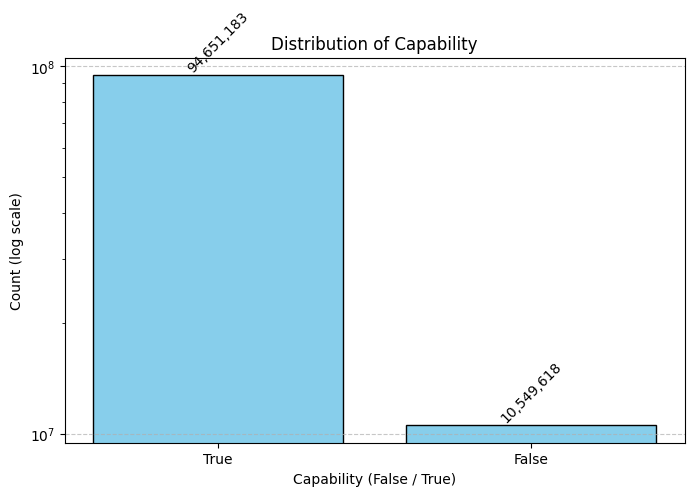

In [11]:
# Contar los valores y convertir a Pandas
counts = result["Capability"].value_counts()

# Asegurar que el índice es booleano y convertirlo a string para evitar problemas de etiquetas
counts.index = counts.index.astype(str)

# Crear la figura y la gráfica de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

# Agregar etiquetas con los valores exactos en cada barra con inclinación
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,}', 
             ha='center', va='bottom', fontsize=10, rotation=45)

# Configurar ejes y título
plt.yscale("log")  # Escala logarítmica para manejar valores grandes
plt.xticks(ticks=[0, 1], labels=["True", "False"])  # Etiquetas específicas en X
plt.xlabel("Capability (False / True)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Capability")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Líneas guía en Y

# Mostrar la gráfica
plt.show()

Visualizamos de nuevo la columna df["Capability"]

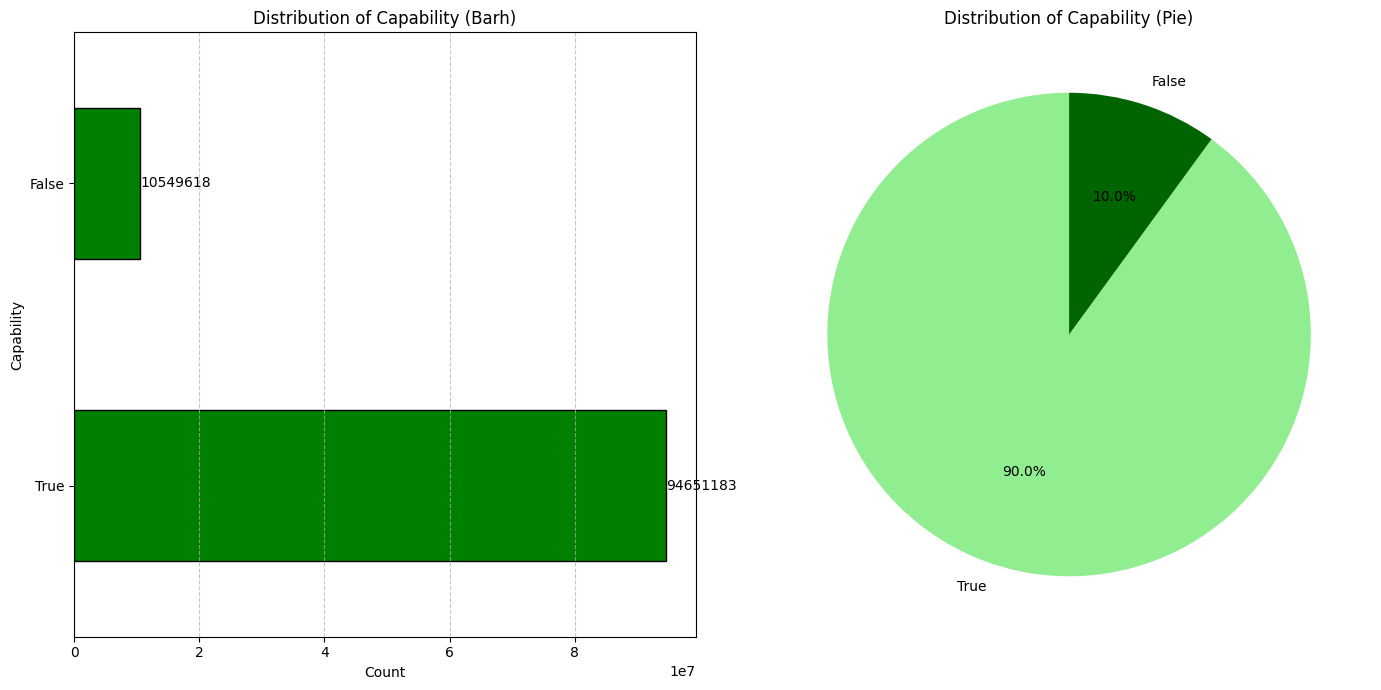

In [12]:
# Contar los valores y convertir a Pandas
counts = result["Capability"].value_counts()

# Crear una figura con dos subgráficas (una fila, dos columnas)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Graficar el conteo en la primera subgráfica (barra horizontal)
counts.plot(kind='barh', color='green', edgecolor='black', ax=axes[0])
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Capability')
axes[0].set_title('Distribution of Capability (Barh)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)  # Agregar líneas de guía

for i, v in enumerate(counts):
    axes[0].text(v + 0.1, i, str(v), color='black', fontsize=10, va='center')

# Graficar el conteo en la segunda subgráfica (gráfico de tarta)
axes[1].pie(counts, labels=counts.index, autopct='%1.1f%%', 
            colors=['lightgreen', 'darkgreen'], startangle=90, textprops={'fontsize': 10})
axes[1].set_title('Distribution of Capability (Pie)')

# Ajustar diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

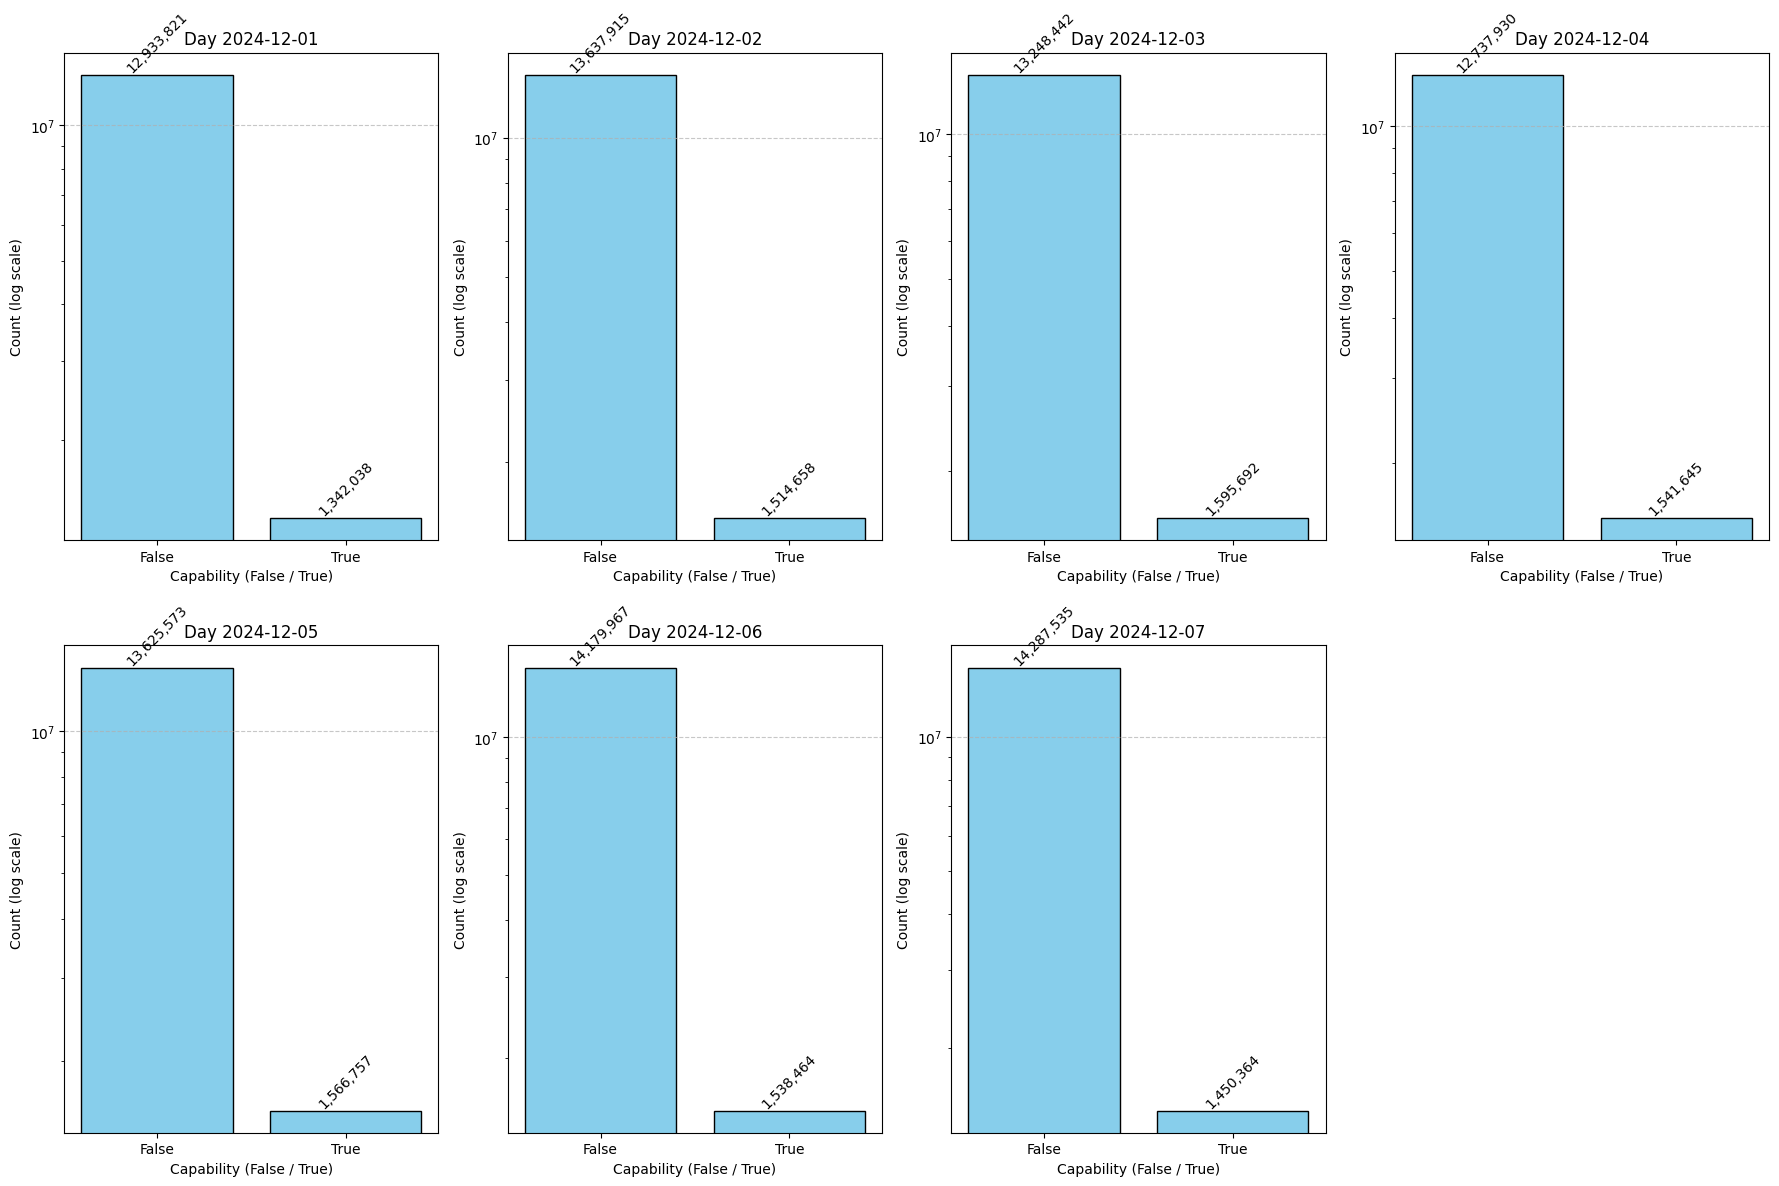

In [15]:
# Ruta a la carpeta donde están los archivos por día
output_folder = Path("output_by_day")

# Obtener la lista de archivos CSV en la carpeta
csv_files = list(output_folder.glob("data_*.csv"))

# Determinar el número de filas y columnas para los subgráficos (6 columnas por fila)
n_rows = (len(csv_files) // 4) + (1 if len(csv_files) % 4 != 0 else 0)
n_cols = 4

# Crear la figura con el tamaño adecuado
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))

# Aplanar el array de ejes para iterar
axes = axes.flatten()

# Crear una gráfica para cada archivo CSV (día)
for i, csv_file in enumerate(csv_files):
    ax = axes[i]

    # Leer el archivo CSV correspondiente al día
    data_day = pd.read_csv(csv_file)

    # Contar los valores de Capability para este día
    counts = data_day["Capability"].value_counts()

    # Asegurar que el índice es booleano y convertirlo a string para evitar problemas de etiquetas
    counts.index = counts.index.astype(str)

    # Graficar las barras para este día
    bars = ax.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

    # Agregar etiquetas con los valores exactos en cada barra con inclinación
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:,}', 
                 ha='center', va='bottom', fontsize=10, rotation=45)

    # Configurar ejes y título
    ax.set_yscale("log")  # Escala logarítmica para manejar valores grandes
    ax.set_xticks(ticks=[0, 1])  # Posiciones de las etiquetas en X
    ax.set_xticklabels(["False", "True"])  # Etiquetas específicas en X
    ax.set_xlabel("Capability (False / True)")
    ax.set_ylabel("Count (log scale)")
    ax.set_title(f"Day {csv_file.stem.split('_')[1]}")  # Extraer la fecha del nombre del archivo
    ax.grid(axis="y", linestyle="--", alpha=0.7)  # Líneas guía en Y

# Ajustar el diseño para que no se sobrepongan
plt.tight_layout()

# Eliminar ejes no utilizados si es necesario
for i in range(len(csv_files), len(axes)):
    fig.delaxes(axes[i])

# Mostrar la figura
plt.show()